In [12]:
import nltk
import re
import os
from glob import glob
import pandas as pd

In [13]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph

In [14]:
from nltk.corpus.reader.dependency import DependencyCorpusReader

In [15]:
import tarfile

# Introduction

## What we do

1.	~~Arabic-NYUAD	629K~~
2.	~~Catalan	472K~~
3.	~~Czech	1,330K~~
4.	~~French	381K~~
5.	~~Hindi	316K~~
6.	~~Russian-SynTagRus	988K~~
7.	~~Spanish-AnCora	495K~~
8.	~~Latin-ITTB	280K~~
9.	~~Portuguese-BR	268K~~
10.	~~Norwegian-Bokmaal	280K~~
11.	~~German	277K~~

Starting Network:
lemmas only; keep punct/symbols; with deprel (labeled edges)

columns:
* lemma-head
* lemma-dep
* deprel
* count

## How to read the log

**IMPORTANT**: Most of the information is now documented in the log file generated by the Python script ("SyntacticNetwork.log"). For each treebank, the log reports:
1. the name of the treebank itself
2. the number of sentences with punctuation as head that were ignored
3. the number of sentences that were examined
4. the Nr. of Tokens included (~200k)

As for point 3, the log reports that information as "Nr. of Sentences included". Unfortunately, that is **NOT** accurate. Considering how the counting of the sentence works, it's clear that the number reported there is the number of sentences that were processed, i.e. the sentences actually included + sentence with punctuation as head (discarded). The real "Nr. of Sentences included" is then calculated as:
`Nr. reported at point 3 - Nr. reported at point 2`

Effectively, the information n. 3 reports the number of sentences that were taken into account, some of which were discarded. That number (-1, if you're indexing them from 0) gives you also the index of the last sentence that was processed.

E.g. the log for the UD_Latin_ITTB reads:

``
INFO:root:Working with treebank: UD_Latin-ITTB
INFO:root:Sentences with punctuation as head: 14
INFO:root:Nr. of Sentences included: 14426
INFO:root:Nr. of Tokens included: 200035
``

14426 are the number of the sentences taken into account. The last sentence analyzed by our script is the Nr. 14426 (or the sentence indexed [14425] if you use a Python corpus reader) of the combined corpus obtained by reading both train and dev file distributed in UD.

The number of sentences that were actually used to obtain our data is: 14426 - 14 (the nr. of sentences discarded, on account of their use of punctuation marks as head).

There is a dummy function where these accounts can be tested in the [Scrapbook](#Scrapbook).

# Extract tar for UD

In [28]:
lgs = ["Hindi", "Russian-SynTagRus", "Spanish-AnCora", "Latin-ITTB", "Portuguese-BR","Norwegian-Bokmaal"]

In [5]:
tar = tarfile.open("/Users/fmambrini/Downloads/Universal Dependencies 2.0/ud-treebanks-conll2017.tgz", "r:gz")

In [29]:
name = lgs[-1]
for tarinfo in tar:
    if name in tarinfo.name:
        print(tarinfo.name)

ud-treebanks-conll2017/UD_Norwegian-Bokmaal
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-dev.txt
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/stats.xml
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-dev.conllu
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-train.conllu
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/README.md
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-train.txt
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/LICENSE.txt


In [25]:
fold = os.path.join("ud-treebanks-conll2017", "UD_French")
subdir_and_files = [tarinfo for tarinfo in tar.getmembers() if tarinfo.name.startswith(fold)]

In [26]:
len(subdir_and_files)

22

The following line of code extracts the selected directory

In [30]:
tar.extractall(members=subdir_and_files)

In [31]:
for l in lgs:
    print("Working with", l)
    fold = os.path.join("ud-treebanks-conll2017", "UD_" + l)
    subdir_and_files = [tarinfo for tarinfo in tar.getmembers() if tarinfo.name.startswith(fold)]
    tar.extractall(members=subdir_and_files)

Working with Hindi
Working with Russian-SynTagRus
Working with Spanish-AnCora
Working with Latin-ITTB
Working with Portuguese-BR
Working with Norwegian-Bokmaal


Then, the next line could be useful to inspect the content

In [32]:
with open("ud-treebanks-conll2017/UD_German/de-ud-dev.conllu") as f:
    lines = f.readlines()

In [33]:
sent = lines[:10]
for s in sent: print(s)

# sent_id = dev-s1

# text = Manasse ist ein einzigartiger Parfümeur.

1	Manasse	Manasse	PROPN	NN	Case=Nom|Number=Sing	5	nsubj	_	_

2	ist	sein	VERB	VAFIN	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	5	cop	_	_

3	ein	ein	DET	ART	Definite=Ind|PronType=Art	5	det	_	_

4	einzigartiger	einzigartig	ADJ	ADJA	Degree=Cmp,Pos	5	amod	_	_

5	Parfümeur	Parfümeur	NOUN	NN	_	0	root	_	SpaceAfter=No

6	.	.	PUNCT	$.	_	5	punct	_	_



# sent_id = dev-s2



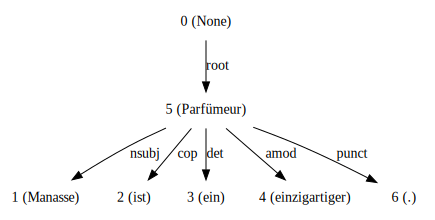

In [132]:
d = DependencyGraph(sent, top_relation_label="root")
d

# Load the corpus

In [16]:
r = "ud-treebanks-conll2017/UD_French/"

## Convert CoNLLu to CoNLLx

The DependencyCorpusReader doesn't work with CoNLLU: we need to convert everything to the old CoNLLX format

In [17]:
fs = glob(r + "*/*.conllu")

In [18]:
fs

[]

In [38]:
for f in fs:
    out = f.replace(".conllu", ".conllx")
    !perl conllu_to_conllx.pl {f} > {out}

## DependencyCorpusReader

The parsed_sents method has a small problem: it assumes "ROOT" as the top relation, yet at least some CoNLLU files have "root"; the all-caps version is what the DependencyGraph object loader expects as default, and there's no way to pass a different value to it. It is however pretty easy to overrite:

In [16]:
def fixed_parsed_sents(self, fileids=None, top_label="root"):
    from nltk.corpus.reader.util import concat
    from nltk.corpus.reader.dependency import DependencyCorpusView
    from nltk.parse import DependencyGraph
    
    sents=concat([DependencyCorpusView(fileid, False, True, True, encoding=enc)
                  for fileid, enc in self.abspaths(fileids, include_encoding=True)])
    return [DependencyGraph(sent, top_relation_label=top_label, cell_separator="\t") for sent in sents]

(see [Section 6](#Fixing-the-problem-with-French) for the fix in line 8: `cell_separator="\t"`)

In [17]:
DependencyCorpusReader.parsed_sents = fixed_parsed_sents

In [19]:
unidep = DependencyCorpusReader(r, r".*\.conllx")

In [20]:
unidep.fileids()

['fr-ud-dev.conllx', 'fr-ud-train.conllx']

In [21]:
#parsed_dev = unidep.parsed_sents('de-ud-dev.conllx')
#parsed_train = unidep.parsed_sents('de-ud-train.conllx')
parsed = unidep.parsed_sents()

AssertionError: 

In [427]:
d = parsed[1]

This is what the triples method yields:

In [299]:
for n in d.triples(): print(n)

(('meditabitur', 'VERB'), 'obj', ('veritatem', 'NOUN'))
(('meditabitur', 'VERB'), 'nsubj:pass', ('guttur', 'NOUN'))
(('guttur', 'NOUN'), 'det', ('meum', 'DET'))
(('meditabitur', 'VERB'), 'conj', ('detestabuntur', 'VERB'))
(('detestabuntur', 'VERB'), 'punct', (',', 'PUNCT'))
(('detestabuntur', 'VERB'), 'cc', ('et', 'CCONJ'))
(('detestabuntur', 'VERB'), 'nsubj:pass', ('labia', 'NOUN'))
(('labia', 'NOUN'), 'det', ('mea', 'DET'))
(('detestabuntur', 'VERB'), 'obj', ('impium', 'ADJ'))
(('meditabitur', 'VERB'), 'punct', ('.', 'PUNCT'))


I would like to be able what kind of column to output there, e.g. whether I want the word or the lemma, or whether the ctag or the full tag. For that we have to ovverrite the method as well...

In [18]:
def new_triples(self, node=None, word_label = "word", tag_label="ctag"):
        """
        Extract dependency triples of the form:
        ((head word, head tag), rel, (dep word, dep tag))
        """
        
        from itertools import chain
        
        assert word_label in ["word", "lemma"], "Select either word or lemma as label!"
        assert tag_label in ["tag", "ctag"], "Select either tag or ctag as label!"

        if not node:
            node = self.root

        head = (node[word_label], node[tag_label])
        for i in sorted(chain.from_iterable(node['deps'].values())):
            dep = self.get_by_address(i)
            yield (head, dep['rel'], (dep[word_label], dep[tag_label]))
            for triple in self.triples(node=dep, word_label=word_label, tag_label=tag_label):
                yield triple

In [19]:
DependencyGraph.triples = new_triples

In [305]:
d.nodes[2]

{'address': 2,
 'ctag': 'VERB',
 'deps': defaultdict(list,
             {'conj': [9], 'nsubj:pass': [3], 'obj': [1], 'punct': [11]}),
 'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Fut|VerbForm=Fin|Voice=Pass',
 'head': 0,
 'lemma': 'meditor',
 'rel': 'root',
 'tag': 'J3|modJ|tem3|gen6|stAC',
 'word': 'meditabitur'}

In [287]:
for n in d.triples(): print(n)

(('meditabitur', 'VERB'), 'obj', ('veritatem', 'NOUN'))
(('meditabitur', 'VERB'), 'nsubj:pass', ('guttur', 'NOUN'))
(('guttur', 'NOUN'), 'det', ('meum', 'DET'))
(('meditabitur', 'VERB'), 'conj', ('detestabuntur', 'VERB'))
(('detestabuntur', 'VERB'), 'punct', (',', 'PUNCT'))
(('detestabuntur', 'VERB'), 'cc', ('et', 'CCONJ'))
(('detestabuntur', 'VERB'), 'nsubj:pass', ('labia', 'NOUN'))
(('labia', 'NOUN'), 'det', ('mea', 'DET'))
(('detestabuntur', 'VERB'), 'obj', ('impium', 'ADJ'))
(('meditabitur', 'VERB'), 'punct', ('.', 'PUNCT'))


In [300]:
for n in d.triples(word_label="lemma", tag_label="ctag"): print(n)

(('meditor', 'VERB'), 'obj', ('veritas', 'NOUN'))
(('meditor', 'VERB'), 'nsubj:pass', ('guttur', 'NOUN'))
(('guttur', 'NOUN'), 'det', ('meus', 'DET'))
(('meditor', 'VERB'), 'conj', ('detestor', 'VERB'))
(('detestor', 'VERB'), 'punct', (',', 'PUNCT'))
(('detestor', 'VERB'), 'cc', ('et', 'CCONJ'))
(('detestor', 'VERB'), 'nsubj:pass', ('labium', 'NOUN'))
(('labium', 'NOUN'), 'det', ('meus', 'DET'))
(('detestor', 'VERB'), 'obj', ('impius', 'ADJ'))
(('meditor', 'VERB'), 'punct', ('.', 'PUNCT'))


It works!

# Generate the network data

We need to extract a series of: Lemma-head -[rel]-> Lemma-dep

Ultimately we need a tab like e.g.:

| Head-Lemma    | Dep-Lemma     | Relation | Count |
| ------------- |:------------- |:-----:   |------:|
| haben         | Gelegenheit   |    obj   | 100   |

So we start collecting a dataframe: head-lemma, dep-lemma, relation

## Collect the data

We decided that:
* feat of dep-rel (e.g. nsubj:pass) are simplified: nsubj:pass >> nsubj
* punctuation is left out (we record on a log the number of cases and the index of sentences where tokens tagged as PUNCT are heads of a relation)
* but before, we cleaned the data: we skipped those sentences where punctuation marks are used as head

In [20]:
def hasPunctHead(parsed_sent):
    for n in parsed_sent.triples():
        if n[0][1] == "PUNCT":
            return True
    return False

In [21]:
def countNodes(parsed_sent):
    """count the tokens in a sentence (purging punctuation);
    :return: int: the count
    """
    i =0
    for k,v in parsed_sent.nodes.items():
        if v["ctag"] == "PUNCT" or v["ctag"] == "TOP":
            continue
        else:
            i +=1
    return i

In [22]:
def getNetworkDataFrames(parsed_sents, threshold=200000):
    """Process the parsed DependencyGraphs and return the DFs with 
    :param: parsed_sents: list of parsed Dependency Graphs
    :param: threshold: the iteration over sentences will stop after the sentence that 
    exceeds the give threshold
    :return: tuple of DataFrames (head-dep values, cooccurence values)
    """
    head, dep, rel = [], [], []
    w1, w2 = [], []
    token_count = 0
    puncthead = 0
    for i,s in enumerate(parsed_sents, start=1):
        if hasPunctHead(s) == False:
            #co-occurence data
            sent = getCoocInSent(s)
            for line in sent:
                w1.append(line[0])
                w2.append(line[1])
            #syntax-based
            for n in s.triples(word_label="lemma"):
                if n[0][1] == 'PUNCT':
                    print("{}: Punctuation as head!".format(i-1))
                    break
                if n[2][1] == "PUNCT":
                    continue
                head.append(n[0][0])
                #htag.append(n[0][1])
                #clean relation feature:
                rel.append(n[1].split(":")[0])
                dep.append(n[2][0])
                #dtag.append(n[2][1])
            token_count = token_count + countNodes(s)
        else:
            puncthead += 1
        if token_count > threshold:
            logging.info("Sentences with punctuation as head: {}".format(puncthead))
            logging.info("Nr. of Sentences included: {}".format(i))
            logging.info("Nr. of Tokens included: {}".format(token_count))
            print("Finalizing the Dataframe at {} tokens after {} sentences".format(token_count, i))
            break
    df_dep = pd.DataFrame({"Head_Lemma" : head, "Dep_Lemma" : dep, "Relation" : rel })
    df_dep = df_dep[["Head_Lemma", "Dep_Lemma", "Relation"]]
    df_co = pd.DataFrame({"Prec": w1, "Seq" : w2})
    return (df_dep, df_co)

In [29]:
df_dep_lemma = getHeadDepDataFrame(parsed)

Finalizing the Dataframe at 200006 tokens after 14184 sentences


In [373]:
len(unidep.words())

280734

In [433]:
df_dep_lemma.tail(20)

,Dep_Lemma,Head_Lemma,Relation
185820,negativní,účinek,amod
185821,doprava,účinek,nmod
185822,silniční,doprava,amod
185823,prostředí,účinek,nmod
185824,na,prostředí,case
185825,životní,prostředí,amod
185826,země,potřebovat,xcomp
185827,jako,země,mark
185828,tranzitní,země,amod
185829,převážně,tranzitní,advmod


## Generate the counts

In [437]:
df_nodeprel = df_dep_lemma[["Dep_Lemma","Head_Lemma"]]

In [438]:
df_nodeprel.head()

,Dep_Lemma,Head_Lemma
0,telefon,rada
1,na,telefon
2,poradit,potřebovat
3,rychle,poradit
4,telefon,zvednout


In [574]:
tab = pd.pivot_table(df_dep_lemma,index=["Dep_Lemma","Head_Lemma", "Relation"], aggfunc=len)

In [440]:
tab_nodep = pd.pivot_table(df_nodeprel, index=["Dep_Lemma","Head_Lemma"], aggfunc=len)

In [576]:
tab.head()

Dep_Lemma  Head_Lemma  Relation
%          %           conj        1
                       orphan      1
           0.2         nmod        1
           0.5         nmod        1
           0.6         nmod        1
dtype: int64

In [580]:
newdf = tab.to_frame("Count")
newdf.reset_index(inplace=True)

In [583]:
newdf.head()

,Dep_Lemma,Head_Lemma,Relation,Count
0,%,%,conj,1
1,%,%,orphan,1
2,%,0.2,nmod,1
3,%,0.5,nmod,1
4,%,0.6,nmod,1


In [585]:
newdf = newdf[["Head_Lemma", "Dep_Lemma", "Relation", "Count"]]

In [586]:
newdf.head()

,Head_Lemma,Dep_Lemma,Relation,Count
0,%,%,conj,1
1,%,%,orphan,1
2,0.2,%,nmod,1
3,0.5,%,nmod,1
4,0.6,%,nmod,1


In [421]:
tab.head()

Dep_Lemma    Head_Lemma  Relation
2-NO-A3---   sum         ccomp       1
4-O--------  causa       mark        1
             deficio     mark        1
             dependeo    mark        1
             semper      mark        1
dtype: int64

In [443]:
tab_nodep.to_csv("cz_syntax_no-deprel.csv", sep="\t", header=True)

# Cooccurrence Network

In [259]:
def getCoocInSent(parsed_sent):
    ns = parsed_sent.nodes
    lemma_list = [ns[w]["lemma"] for w in ns.keys() 
              if ns[w]["lemma"] != None and ns[w]["ctag"] != "PUNCT"]
    return list(bigrams(lemma_list))

In [263]:
def coocData(parsed_sents):
    w1, w2 = [], []
    for s in parsed_sents:
        sent = getCoocInSent(s)
        for line in sent:
            w1.append(line[0])
            w2.append(line[1])
    return pd.DataFrame({"Prec": w1, "Seq" : w2})

In [261]:
getCoocInSent(d)

[('multitudo', 'usus'),
 ('usus', 'qui'),
 ('qui', 'in'),
 ('in', 'res'),
 ('res', 'nomino'),
 ('nomino', 'sequor'),
 ('sequor', 'philosophus'),
 ('philosophus', 'censeo'),
 ('censeo', 'communis'),
 ('communis', 'obtineo'),
 ('obtineo', 'ut'),
 ('ut', 'sapiens'),
 ('sapiens', 'dico'),
 ('dico', 'qui'),
 ('qui', 'res'),
 ('res', 'directus'),
 ('directus', 'ordino'),
 ('ordino', 'et'),
 ('et', 'is'),
 ('is', 'bene'),
 ('bene', 'guberno')]

In [257]:
from nltk import bigrams

In [251]:
d = parsed[3]

In [252]:
print(d.to_conll(3))

multitudinis	C1|grn1|casB|gen2|stRS	2
usus	D1|grn1|casA|gen1|stAN	13
,	Punc	10
quem	F1|grn1|casD|gen1|stPV	10
in	S4|stRL	6
rebus	E1|grn1|casO|gen2|stRS	8
nominandis	J2|modO|grp1|casO|gen2|stAE	6
sequendum	L2|modO|grp1|casD|gen1|stAV	10
philosophus	B1|grn1|casA|gen1|stRS	10
censet	K3|modA|tem1|gen6|stAC	2
,	Punc	10
communiter	C1|grn1|casG|stAN	13
obtinuit	K3|modA|tem4|gen6|stAV	0
ut	O4|vgr1|stRL	15
sapientes	C1|grn1|casJ|gen1|stAC	13
dicantur	L3|modK|tem1|gen9|stAE	15
qui	F1|grn1|casJ|gen1|stPV	20
res	E1|grn1|casM|gen2|stRS	20
directe	B1|grn1|casG|stAV	20
ordinant	J3|modA|tem1|gen9|stAV	15
et	O4|stRL	24
eas	F1|grn1|casM|gen2|stPV	24
bene	O4|stRL	24
gubernant	J3|modA|tem1|gen9|stAV	20
.	Punc	13



In [253]:
ns = d.nodes
lemma_list = [ns[w]["lemma"] for w in ns.keys() 
              if ns[w]["lemma"] != None and ns[w]["ctag"] != "PUNCT"]

In [254]:
lemma_list

['multitudo',
 'usus',
 'qui',
 'in',
 'res',
 'nomino',
 'sequor',
 'philosophus',
 'censeo',
 'communis',
 'obtineo',
 'ut',
 'sapiens',
 'dico',
 'qui',
 'res',
 'directus',
 'ordino',
 'et',
 'is',
 'bene',
 'guberno']

In [264]:
list(bigrams(lemma_list))

[('multitudo', 'usus'),
 ('usus', 'qui'),
 ('qui', 'in'),
 ('in', 'res'),
 ('res', 'nomino'),
 ('nomino', 'sequor'),
 ('sequor', 'philosophus'),
 ('philosophus', 'censeo'),
 ('censeo', 'communis'),
 ('communis', 'obtineo'),
 ('obtineo', 'ut'),
 ('ut', 'sapiens'),
 ('sapiens', 'dico'),
 ('dico', 'qui'),
 ('qui', 'res'),
 ('res', 'directus'),
 ('directus', 'ordino'),
 ('ordino', 'et'),
 ('et', 'is'),
 ('is', 'bene'),
 ('bene', 'guberno')]

In [265]:
df_cooc = coocData(parsed)

In [277]:
df_cooc.head(5)

,Prec,Seq
0,qui,sum
1,sum,officium
2,officium,sapiens
3,veritas,meditor
4,meditor,guttur


In [274]:
words = unidep.words()

# Fixing the problem with French

The parsing of the French data with the DependencyGraph class raises an Assertion Error. We'll try to diagnose it and fix it

In [23]:
from nltk.corpus.reader.util import concat
from nltk.corpus.reader.dependency import DependencyCorpusView

In [26]:
sents=concat([DependencyCorpusView(fileid, False, True, True, encoding=enc)
                  for fileid, enc in unidep.abspaths(unidep.fileids(), include_encoding=True)])

In [37]:
wrong_sent = []
for i,s in enumerate(sents):
    try:
        d = DependencyGraph(s, top_relation_label="root")
    except AssertionError:
        wrong_sent.append((i, s))
        print("Assertion error at sentence {} ({})".format(i, s[:20]))

Assertion error at sentence 16 (1	Comprenant	compren)
Assertion error at sentence 91 (1	Le	le	DET	DET	Defi)
Assertion error at sentence 108 (1	Entremont	Entremon)
Assertion error at sentence 195 (1	Celui-ci	celui-ci	)
Assertion error at sentence 209 (1	Les	le	DET	DET	Def)
Assertion error at sentence 369 (1	Selon	selon	ADP	AD)
Assertion error at sentence 395 (1	La	le	DET	DET	Defi)
Assertion error at sentence 590 (1	En	en	ADP	ADP	_	2	)
Assertion error at sentence 808 (1	Les	le	DET	DET	Def)
Assertion error at sentence 864 (1	Sa	son	DET	DET	Gen)
Assertion error at sentence 902 (1	de	de	ADP	ADP	_	3	)
Assertion error at sentence 1147 (1	Environ	environ	AD)
Assertion error at sentence 1550 (1	À	à	ADP	ADP	_	6	ca)
Assertion error at sentence 1618 (1	Le	le	DET	DET	Defi)
Assertion error at sentence 1636 (1	La	le	DET	DET	Defi)
Assertion error at sentence 1707 (1	Elle	elle	PRON	PRO)
Assertion error at sentence 1717 (1	Graham	Graham	PROP)
Assertion error at sentence 1737 (1	Avec	avec	ADP	ADP	)
Asser

In [35]:
len(wrong_sent)

126

In [36]:
print(wrong_sent[0][1])

1	Comprenant	comprendre	VERB	VERB	Tense=Pres|VerbForm=Part	17	acl	_	_
2	six	six	NUM	NUM	_	3	nummod	_	_
3	sommets	sommet	NOUN	NOUN	Gender=Masc|Number=Plur	1	obj	_	_
4	dont	dont	PRON	PRON	PronType=Rel	6	nmod	_	_
5	un	un	DET	DET	Definite=Ind|Gender=Masc|Number=Sing|PronType=Art	6	det	_	_
6	point	point	NOUN	NOUN	Gender=Masc|Number=Sing	3	appos	_	_
7	culminant	culminer	VERB	VERB	Tense=Pres|VerbForm=Part	6	acl	_	_
8	à	à	ADP	ADP	_	10	case	_	_
9	2 001	2 001	NUM	NUM	_	10	nummod	_	_
10	mètres	mètre	NOUN	NOUN	Gender=Masc|Number=Plur	7	obl	_	_
11	et	et	CCONJ	CCONJ	_	13	cc	_	_
12	une	un	DET	DET	Definite=Ind|Gender=Fem|Number=Sing|PronType=Art	13	det	_	_
13	arrivée	arrivée	NOUN	NOUN	Gender=Fem|Number=Sing	6	conj	_	_
14	en	en	ADP	ADP	_	15	case	_	_
15	altitude	altitude	NOUN	NOUN	Gender=Fem|Number=Sing	13	nmod	_	_
16	,	,	PUNCT	PUNCT	_	1	punct	_	_
17	c'	ce	PRON	PRON	Number=Sing|Person=3|PronType=Dem	20	nsubj	_	_
18	est	être	AUX	AUX	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	20	cop	_	_
19	une	

In [53]:
inp = wrong_sent[1][1]

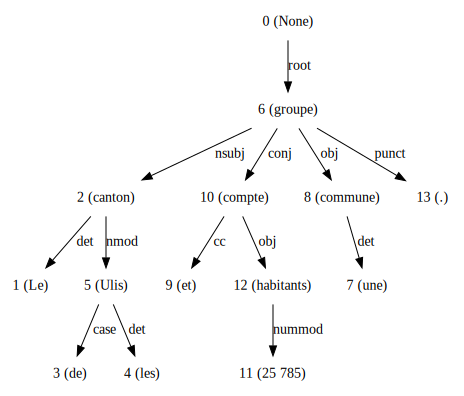

In [54]:
DependencyGraph(inp,cell_separator="\t", top_relation_label="root")

It's clear what's messing up the script! The parser has trouble with the cell separator in cases like that:
* ' in word's final position (as in "c'" of wrong_sents[0], word 17)
* space in the word (as in "25 785" of wrong_sents[1])

That's easily fixed. It suffices to esplicitely set `cell_separator="\t"` for the DependencyGraph constructor in our new verions of `fixed_parsed_sents`. As tab is the official separator of CoNLL-U, this should give no problem at all to the other treebanks: I tested it with a couple of them and all went smoothly...

# Fixing the problem with Portuguese

For some reasons, the log on the Portuguese TB reports that 200006 tokens and 8725 sentences were analyzed. The output, however, only holds one sentence and only a very few words

In [24]:
import syntacticNetwork as sn

In [25]:
pt_root = "/Users/fmambrini/Documents/lavoro/github/research-projects/UniversalDepNetwork/ud-treebanks-conll2017/UD_Portuguese-BR"

In [27]:
unidep = sn.DependencyCorpusReader(pt_root, r".*\.conllx")

In [28]:
parsed = unidep.parsed_sents()

In [40]:
len(unidep.sents())

10874

In [42]:
print(unidep.sents()[0])

['Até', 'agora', 'o', 'Brasil', 'conquistou', '8', 'medalhas', '(', '2', 'ouros', ',', '1', 'prata', 'e', '5', 'bronzes', ')', 'e', 'tem', 'mais', 'quatro', 'pódios', 'garantidos', ':', 'dois', 'en', 'o', 'boxe', ',', 'um', 'en', 'o', 'vôlei', 'de', 'praia', 'masculino', 'e', 'um', 'en', 'o', 'futebol', 'masculino', '.']


In [34]:
p  = parsed[0]

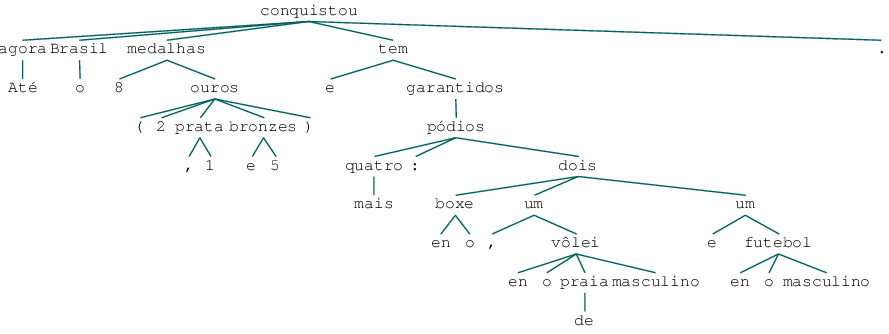

In [44]:
p.tree()

In [45]:
df_raw_dep, df_raw_co = sn.getNetworkDataFrames(parsed, threshold=200000)

Finalizing the Dataframe at 200006 tokens after 8725 sentences


In [ ]:
unidep.

# Scrapbook 

Let's test if it is true that the sentences included in the study is = nr. of sents reported in the log - nr. of sentences with punct as head

In [103]:
from syntacticNetwork import getCoocInSent, hasPunctHead
def TEST_NetworkDataFrames(parsed_sents, threshold=200000):
    """Process the parsed DependencyGraphs and return the DFs with 
    :param: parsed_sents: list of parsed Dependency Graphs
    :param: threshold: the iteration over sentences will stop after the sentence that 
    exceeds the give threshold
    :return: tuple of DataFrames (head-dep values, cooccurence values)
    """
    head, dep, rel = [], [], []
    w1, w2 = [], []
    token_count = 0
    puncthead = 0
    included_sents = []
    for i,s in enumerate(parsed_sents, start=1):
        if hasPunctHead(s) == False:
            included_sents.append((i,s))
            #co-occurence data
            sent = getCoocInSent(s)
            for line in sent:
                w1.append(line[0])
                w2.append(line[1])
            #syntax-based
            for n in s.triples(word_label="lemma"):
                if n[0][1] == 'PUNCT':
                    print("{}: Punctuation as head!".format(i-1))
                    break
                if n[2][1] == "PUNCT":
                    continue
                head.append(n[0][0])
                #htag.append(n[0][1])
                #clean relation feature:
                rel.append(n[1].split(":")[0])
                dep.append(n[2][0])
                #dtag.append(n[2][1])
            token_count = token_count + countNodes(s)
        else:
            puncthead += 1
        if token_count > threshold:
            print("Sentences with punctuation as head: {}".format(puncthead))
            #logging.info("Nr. of Sentences included: {}".format(i))
            #logging.info("Nr. of Tokens included: {}".format(token_count))
            print("Finalizing the Dataframe at {} tokens after {} sentences".format(token_count, i))
            break
    #df_dep = pd.DataFrame({"Head_Lemma" : head, "Dep_Lemma" : dep, "Relation" : rel })
    #df_dep = df_dep[["Head_Lemma", "Dep_Lemma", "Relation"]]
    #df_co = pd.DataFrame({"Prec": w1, "Seq" : w2})
    return (included_sents)

In [100]:
unidep.fileids()

['de-ud-dev.conllx', 'de-ud-train.conllx']

In [104]:
inc = TEST_NetworkDataFrames(parsed)

Sentences with punctuation as head: 11
Finalizing the Dataframe at 200010 tokens after 12396 sentences


In [102]:
len(inc)

12385

Which is indeed 12396 - 11!